# demo: find drifter under swath

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

#from pyproj import Geod, Proj
import geopandas as gpd
import shapely as shp
from shapely.geometry import Polygon

### utils

In [63]:

def build_swath_polygon(da, x="x", y="y", dix = 50, diy = 50, side=None):
    """ build a shapely polygon of swot swath

    Parameters
    ----------
    da: xr.Dataset, xr.DataArray
        Input dataset where coordinates x/y are found
    x, y: str, optional
        Coordinates to use to define bounds
    dix, diy: int, optional
        Subsampling steps in num_pixels and num_lines directions
    side: str, optional
        take either the polygon for the full swath, or the right/left ones
    """

    # right swath
    if side=="left":
        da = da.isel(num_pixels=slice(0, da.num_pixels.size//2))
    elif side=="right":
        da = da.isel(num_pixels=slice(da.num_pixels.size//2, -1))
            
    nx = da.num_pixels.size
    ny = da.num_lines.size
        
    rg = lambda size, di: list(range(0, size, dix))+[size-1]
    
    X, Y = [], []
    
    e = da.isel(num_lines=0, num_pixels=rg(nx, dix))
    X += list(e[x].data)
    Y += list(e[y].data)
    
    e = da.isel(num_lines=-1, num_pixels=rg(nx, dix))
    X += list(e[x].data)
    Y += list(e[y].data)
    
    e = da.isel(num_lines=rg(ny,diy), num_pixels=0)
    X += list(e[x].data)
    Y += list(e[y].data)
    
    e = da.isel(num_lines=rg(ny,diy), num_pixels=-1)
    X += list(e[x].data)
    Y += list(e[y].data)
    
    mpt = shp.MultiPoint([[x, y] for x, y in zip(X, Y)])
    poly = mpt.convex_hull

    return poly

#def is_inside(poly, *args):
#    if len(args)==2:
#        pt = shp.Point(*args)
#    else:
#        pt = args[0]
#    return poly.contains(pt)

### load data

In [ ]:
swot = xr.open_zarr(
    "/home/datawork-lops-osi/aponte/swot/cswot/swot/l3_v1.0.1/3_500.zarr"
).compute()

In [ ]:
dr = xr.open_dataset(
    "/home/datawork-lops-osi/aponte/swot/cswot/drifters_harmonized/L2/all_med_variational_1h_v0.nc"
)

In [ ]:
# build swath polygons
both = build_swath_polygon(swot, x="longitude", y="latitude", dix = 50, diy = 50, side=None)
left = build_swath_polygon(swot, x="longitude", y="latitude", dix = 50, diy = 50, side="left")
right = build_swath_polygon(swot, x="longitude", y="latitude", dix = 50, diy = 50, side="right")

In [ ]:
# stack dimensions
drs = dr.stack(points=("datetime", "drifter_id"))
lon, lat = drs.longitude.fillna(0.).values, drs.latitude.fillna(0.).values

In [67]:
# test if points inside left swath
drs["inside_left"] = (
    "points", 
    np.array([left.contains(shp.Point(_lon, _lat)) for _lon, _lat in zip(lon, lat)]),
)

In [76]:
# put mask inside original dataset
dr["inside_left"] = drs["inside_left"].unstack()

# masked dataset
dr_left = dr.where(dr["inside_left"])

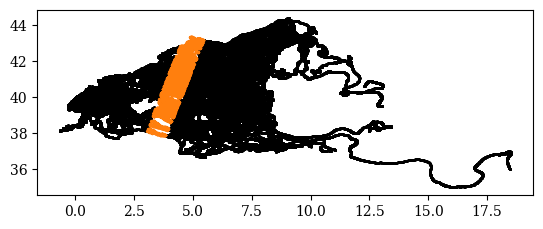

In [81]:
fig, ax = plt.subplots(1,1)
ax.scatter(dr.longitude, dr.latitude, c="k", s=1)
ax.scatter(dr_left.longitude, dr_left.latitude, c="C1", s=2)
ax.set_aspect(np.cos(np.deg2rad(40)))

### play with geopandas

In [ ]:
gdf = gpd.GeoDataFrame(dict(i=range(3)), geometry=[both, left, right],index=["both", "left", "right"])

In [ ]:
gdf.loc[["both"]].plot()

In [ ]:
gdf.plot(column="i", alpha=.8)